<a href="https://colab.research.google.com/github/appunite/Wire-RAG/blob/main/main_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Wire RAG

In [15]:
import os
import getpass
os.environ["PINECONE_API_KEY"] = getpass.getpass("pinecone api key")
os.environ["OPENAI_API_KEY"] = getpass.getpass("open ai api key")

pinecone api key··········
open ai api key··········


In [ ]:
!pip install haystack-ai pinecone-haystack sentence-transformers pinecone transformers

### Scrape Urls

In [2]:
import aiohttp
import asyncio
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import nest_asyncio

# Apply the nest_asyncio patch to allow nested event loops in Jupyter
nest_asyncio.apply()

# Asynchronous URL fetching with retry logic
async def fetch_urls(url, session, retries=3):
    attempt = 0
    while attempt < retries:
        try:
            async with session.get(url, timeout=15) as response:
                if response.status != 200:
                    return set()  # Return an empty set if the page doesn't load
                content = await response.text()
                soup = BeautifulSoup(content, "html.parser")
                urls = set(
                    urljoin(url, link['href'])
                    for link in soup.find_all('a', href=True)
                    if urlparse(urljoin(url, link['href'])).scheme in ('http', 'https')
                )
                # if attempt > 0:
                #     print(f"Successfully fetched URL: {url} on attempt {attempt + 1}")
                return urls
        except (aiohttp.ClientError, asyncio.TimeoutError) as e:
            attempt += 1
            if attempt < retries:
                await asyncio.sleep(2 ** attempt)  # Exponential backoff
        except Exception as e:
            return set()

    print(f"Failed to fetch URL {url} after {retries} attempts.")
    return set()

# Check if URL should be allowed based on blacklist/whitelist mode
def is_url_allowed(url, black_list_data):
    url_list = black_list_data["list"]
    is_blacklist_mode = black_list_data["black_list"]

    parsed_url = urlparse(url)
    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"

    if is_blacklist_mode:
        # Blacklist mode: block URLs matching any blacklist entry
        for entry in url_list:
            entry_parsed = urlparse(entry)
            entry_base = f"{entry_parsed.scheme}://{entry_parsed.netloc}"
            if entry_base == base_url and url.startswith(entry):
                return False
            # Specifically check if the entry is a path that should be blocked
            if entry_parsed.netloc == parsed_url.netloc and urlparse(entry).path == parsed_url.path:
                return False
    else:
        # Whitelist mode: only allow URLs matching any whitelist entry
        return any(
            url.startswith(entry) or f"{urlparse(entry).scheme}://{urlparse(entry).netloc}" == base_url
            for entry in url_list
        )

    return True

# Asynchronous scraping with blacklist/whitelist and depth handling
async def scrape_urls(url, session, max_depth, current_depth=0, visited=None, black_list_data=None):
    if visited is None:
        visited = []

    if current_depth > max_depth:
        return visited  # Stop recursion if depth limit exceeded

    if not is_url_allowed(url, black_list_data):
        return visited  # Skip URL if not allowed

    visited.append(url)  # Store URL with its depth

    # Extract URLs from the current page
    urls = await fetch_urls(url, session)

    tasks = []
    for new_url in urls:
        if new_url not in visited and is_url_allowed(new_url, black_list_data):
            # Continue scraping at the next depth level if within depth limit
            if current_depth < max_depth:
                tasks.append(scrape_urls(new_url, session, max_depth, current_depth + 1, visited, black_list_data))

    # Await all the tasks concurrently
    await asyncio.gather(*tasks)
    return visited

# Entry point for asynchronous scraping
async def start_scraping(url, depth, black_list_data=None):
    async with aiohttp.ClientSession() as session:
        found_urls = await scrape_urls(url, session, depth, black_list_data=black_list_data)
    return found_urls

In [ ]:
starting_url = "https://docs.wire.com"
depth_limit = 2
whitelist = {"list": ["https://docs.wire.com"], "black_list": False}

scraped_urls = await start_scraping(starting_url, depth_limit, whitelist)

print(f"Total URLs found: {len(scraped_urls)}")

Extract headlines and content

In [4]:
from genericpath import exists
import requests
import re

from bs4 import BeautifulSoup
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from collections import defaultdict

def requests_retry_session(
    retries=3,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session


def extract_headlines_and_content(url):
    try:
        # Use retry session for robust requests
        session = requests_retry_session()
        response = session.get(url, timeout=10)

        # Check if request was successful
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')

        content_by_headline = {}
        current_header = None

        # Loop through the elements, keeping track of headlines and paragraphs
        for element in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p', 'ul', 'ol']):
            if element.name.startswith('h'):
                # Headline
                current_header = element.get_text(strip=True)
                current_header = current_header.replace("\n", "")
                current_header = re.sub(r"\s+", " ", current_header)

            elif element.name in ['p', 'ul', 'ol'] and current_header:
                # Append the text under the last seen headline
                value = content_by_headline[current_header] if current_header in content_by_headline else ""
                content_by_headline[current_header] = f"{value} {element.get_text(strip=True)}"

        return content_by_headline

    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

In [5]:
all_documents = []

for url in scraped_urls:
    content_by_headline = extract_headlines_and_content(url)
    # print(content_by_headline, "\n\n\n")

    all_documents.append(content_by_headline)

To delete all records u need to `pip install "pinecone[grpc]"` and run the following code.

In [6]:
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.writers import DocumentWriter
from haystack import Pipeline
from haystack import Document
from haystack_integrations.document_stores.pinecone import PineconeDocumentStore

document_store = PineconeDocumentStore(
		index="default",
		namespace="default",
		dimension=384,
  	metric="cosine",
  	spec={"serverless": {"region": "us-east-1", "cloud": "aws"}}
)

ready_list = []
for d in all_documents:
	for key in d:
		headline = key
		content = d[key]
	document = Document(content=content, meta={"headline": headline})
	ready_list.append(document)

document_joiner = DocumentJoiner()
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=150, split_overlap=50)
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)

Create a pipeline to populate the Pinecone Document Store with test case documents

In [ ]:
preprocessing_pipeline = Pipeline()

preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")
preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")

preprocessing_pipeline.connect("document_joiner", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")

Run the pipeline

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Upserted vectors:   0%|          | 0/221 [00:00<?, ?it/s]

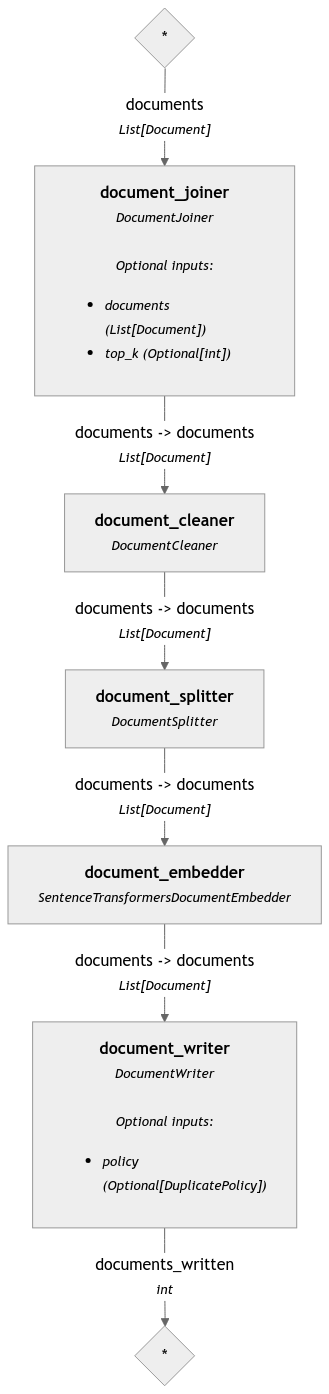

In [12]:
from pathlib import Path

preprocessing_pipeline.run(data = {"document_joiner": { "documents" : ready_list }})
# preprocessing_pipeline.inputs()
preprocessing_pipeline.show()

## Test RAG with Pinecone Document Store

Restart the kernel and run the following code to test the RAG pipeline with the populated Pinecone Document Store.

Initialize Pinecone

Prepare pipeline components

Create pipeline to run a query

In [ ]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.pinecone import PineconeEmbeddingRetriever
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack import Pipeline

template = """
    Given these documents, answer the question.\nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{question}}
    \nAnswer:
"""

document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = PineconeEmbeddingRetriever(document_store=document_store)
generator = OpenAIGenerator()
answer_builder = AnswerBuilder()
prompt_builder = PromptBuilder(template=template)

rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component("answer_builder", answer_builder)

rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("retriever", "answer_builder.documents")

Run the pipeline with a query

In [ ]:
# query = "Generate full documentation of DataAnalyzer project"
query = "Show me new changes from changelog"
result = rag_pipeline.run({
    "text_embedder": {"text": query},
    "prompt_builder": {"question": query},
    "answer_builder": {"query": query}
})

print(result['answer_builder']['answers'][0].query)
print(result['answer_builder']['answers'][0].data)
print(result['answer_builder']['answers'][0].documents)

with open("output.md", "w") as f:
    f.write(result['answer_builder']['answers'][0].data)